In [1871]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
# In terminal: pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

PCOS = pd.read_csv("PCOS.csv")

In [1955]:
def confusion_matrix_train(model, cutoff=0.5):
# Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print(cm_df)
    print("\nClassification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

In [1956]:
def confusion_matrix_test(data,actual_values,model,cutoff=0.3):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    # Return the confusion matrix and the accuracy
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print(cm_df)
    print("\nClassification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

# Data Cleaning

PCOS (Y/N): Age (C), Weight(C), pulse rate (C), RR (C), BMI (C), Years of marriage (C), Pregnant (B), Fast Food (B), Regular Exercise (B), No. of abortions (C), cycle length (c), waist/hip ratio (C), hair growth (B), pimples (B), blood group (cat)


In [1874]:
PCOS.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', 'Age (yrs)', 'Weight (Kg)',
       'Height(Cm)', 'BMI', 'Blood Group', 'Pulse rate(bpm)',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [1875]:
data = PCOS.loc[:, ["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "Hip(inch)", "Waist(inch)", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group",
                   "Skin darkening (Y/N)"]]

# Organizing data
data["H/W Ratio"] = data["Hip(inch)"]/data["Waist(inch)"]
data["Height(M)"] = data["Height(Cm)"]/100
data["BMI"] = data["Weight (Kg)"]/np.square(data["Height(M)"])
data = data.reindex(columns=["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "H/W Ratio", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group", "Skin darkening (Y/N)"])
data.isnull().sum()

PCOS (Y/N)               0
Age (yrs)                0
Weight (Kg)              0
Height(Cm)               0
BMI                      0
Pulse rate(bpm)          0
RR (breaths/min)         0
Marraige Status (Yrs)    1
Fast food (Y/N)          1
Pregnant(Y/N)            0
No. of aborptions        0
H/W Ratio                0
Reg.Exercise(Y/N)        0
Cycle(R/I)               0
hair growth(Y/N)         0
Pimples(Y/N)             0
Blood Group              0
Skin darkening (Y/N)     0
dtype: int64

In [1876]:
data = data[~((data['Marraige Status (Yrs)'].isnull()) | (data['Fast food (Y/N)'].isnull()))]

In [1877]:
# Adding in missing values with mean of other values
#missing_cols = data.columns[data.isna().any()].tolist()
#for x in missing_cols:
#    data[x] = data[x].fillna(data[x].mean())

In [1878]:
data

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Pulse rate(bpm),RR (breaths/min),Marraige Status (Yrs),Fast food (Y/N),Pregnant(Y/N),No. of aborptions,H/W Ratio,Reg.Exercise(Y/N),Cycle(R/I),hair growth(Y/N),Pimples(Y/N),Blood Group,Skin darkening (Y/N)
0,0,28,44.6,152.000,19.304017,78,22,7.0,1.0,0,0,1.200000,0,2,0,0,15,0
1,0,36,65.0,161.500,24.921163,74,20,11.0,0.0,1,0,1.187500,0,2,0,0,15,0
2,1,33,68.8,165.000,25.270891,72,18,10.0,1.0,1,0,1.111111,0,2,0,1,11,0
3,0,37,65.0,148.000,29.674945,72,20,4.0,0.0,0,0,1.166667,0,2,0,0,13,0
4,0,25,52.0,161.000,20.060954,72,18,1.0,0.0,1,0,1.233333,0,2,0,0,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,35,50.0,164.592,18.456637,72,16,8.0,0.0,0,1,1.076923,0,2,0,0,17,0
537,0,30,63.2,158.000,25.316456,72,18,4.0,0.0,1,1,1.062500,0,2,0,0,15,0
538,0,36,54.0,152.000,23.372576,74,20,8.0,0.0,0,0,1.071429,0,2,0,0,13,0
539,0,27,50.0,150.000,22.222222,74,20,2.0,0.0,0,0,1.076923,0,4,0,1,15,0


# Use SMOTE to generate more values

In [1879]:
data["PCOS (Y/N)"].value_counts()

0    363
1    176
Name: PCOS (Y/N), dtype: int64

In [1880]:
X=data.iloc[:,1:]
X.isnull().sum()
y=data.iloc[:,0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 20)

In [1881]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 144
Before OverSampling, counts of label '0': 287 

After OverSampling, the shape of train_X: (574, 17)
After OverSampling, the shape of train_y: (574,) 

After OverSampling, counts of label '1': 287
After OverSampling, counts of label '0': 287


In [1882]:


y = pd.DataFrame(y_train_res, columns=["PCOS (Y/N)"])

In [1883]:
data = pd.concat([X_train_res, y], axis = 1) 
data = data.reindex(columns=["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "H/W Ratio", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group", "Skin darkening (Y/N)"])
data = data.rename(columns={"PCOS (Y/N)":"PCOS", "Age (yrs)":"age", "Weight (Kg)": "weight", "Height(Cm)": "height", "Pulse rate(bpm)": "pulse_rate", "RR (breaths/min)": "RR", "Marraige Status (Yrs)": "marriage_years", 'Fast food (Y/N)': "fast_food", "Pregnant(Y/N)": "pregnant", "No. of aborptions": "number_abortions", "H/W Ratio": "hw_ratio", "Reg.Exercise(Y/N)": "regular_exercise", "Cycle(R/I)": "cycle", "hair growth(Y/N)": "hair_growth", "Pimples(Y/N)": "pimples",
                           "Skin darkening (Y/N)":'skin_dark'})
data.head()


,PCOS,age,weight,height,BMI,pulse_rate,RR,marriage_years,fast_food,pregnant,number_abortions,hw_ratio,regular_exercise,cycle,hair_growth,pimples,Blood Group,skin_dark
0,0,36,52.0,150.0,23.111111,80,20,4.0,0.0,0,0,1.052632,0,4,0,0,15,0
1,0,36,64.0,150.0,28.444444,72,18,13.0,0.0,1,0,1.085714,0,2,1,1,13,0
2,1,33,68.8,165.0,25.270891,72,18,10.0,1.0,1,0,1.111111,0,2,0,1,11,0
3,1,34,72.0,158.0,28.841532,72,18,13.0,1.0,0,1,1.085714,0,4,1,1,13,0
4,0,39,61.0,152.0,26.402355,72,18,20.0,0.0,0,3,1.058824,1,2,0,0,11,0


In [1884]:
data.shape

(574, 18)

### Changing Blood Group into categories

In [1885]:
blood_group_map = {11: "A+", 12: "A-", 13: "B+", 14: "B-", 15: "O+", 16: "O-", 17: "AB+", 18: "AB-"}

data.loc[:, "blood_group_cat"] = data.loc[:, "Blood Group"].map(blood_group_map)
data.head()

,PCOS,age,weight,height,BMI,pulse_rate,RR,marriage_years,fast_food,pregnant,number_abortions,hw_ratio,regular_exercise,cycle,hair_growth,pimples,Blood Group,skin_dark,blood_group_cat
0,0,36,52.0,150.0,23.111111,80,20,4.0,0.0,0,0,1.052632,0,4,0,0,15,0,O+
1,0,36,64.0,150.0,28.444444,72,18,13.0,0.0,1,0,1.085714,0,2,1,1,13,0,B+
2,1,33,68.8,165.0,25.270891,72,18,10.0,1.0,1,0,1.111111,0,2,0,1,11,0,A+
3,1,34,72.0,158.0,28.841532,72,18,13.0,1.0,0,1,1.085714,0,4,1,1,13,0,B+
4,0,39,61.0,152.0,26.402355,72,18,20.0,0.0,0,3,1.058824,1,2,0,0,11,0,A+


# EDA

### Testing if age needs transformation

<AxesSubplot:xlabel='PCOS', ylabel='age'>

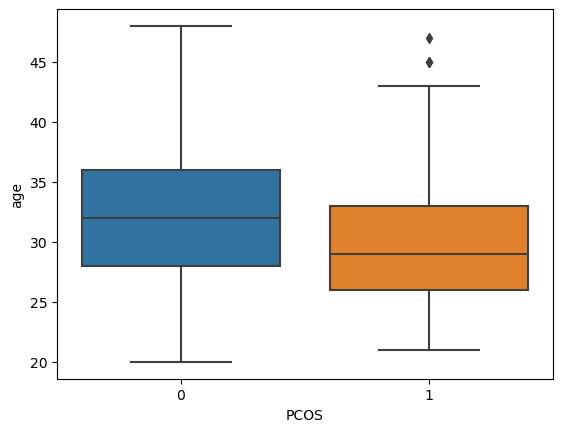

In [1886]:
sns.boxplot(x = 'PCOS', y = 'age', data = data)

In [1887]:
#Binning Age
binned_age = pd.qcut(data['age'], 10, retbins=True)
data['age_binned'] = binned_age[0]

In [1888]:
#Finding percentage of people having diabetes in each Age bin
age_data = data.groupby('age_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
age_data

,age_binned,PCOS_percent,nobs
0,"(19.999, 24.0]",0.703125,64
1,"(24.0, 26.0]",0.507937,63
2,"(26.0, 27.0]",0.673077,52
3,"(27.0, 29.0]",0.651685,89
4,"(29.0, 30.0]",0.487179,39
5,"(30.0, 32.0]",0.352113,71
6,"(32.0, 33.0]",0.642857,28
7,"(33.0, 35.0]",0.460317,63
8,"(35.0, 38.0]",0.206897,58
9,"(38.0, 48.0]",0.297872,47


Text(0.5, 0, 'Age_bin')

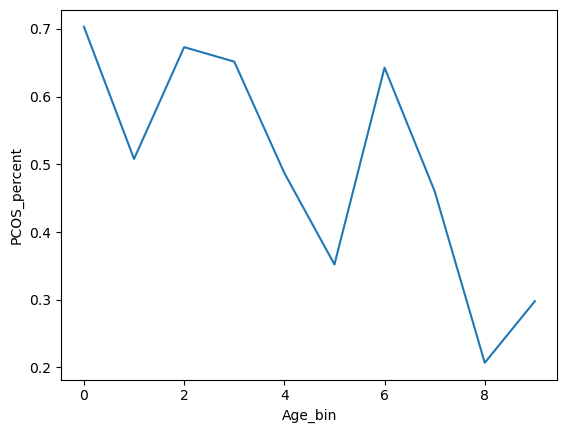

In [1889]:
sns.lineplot(x = age_data.index, y = age_data['PCOS_percent'])
plt.xlabel('Age_bin')

We observe that the probability of people having PCOS does not keep decreasing monotonically with age. However, it is still relatively linear, so we do not need to perform a transformation.

### Testing if BMI needs transformation

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

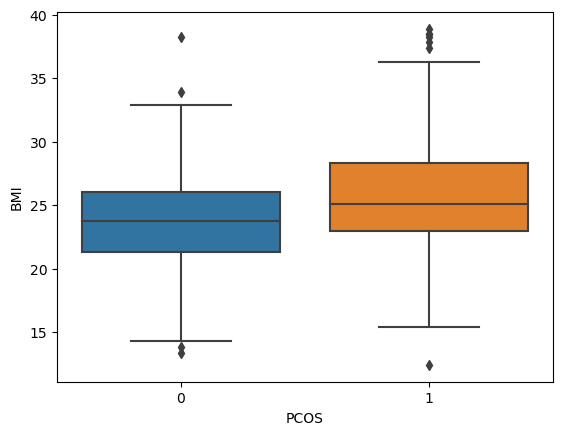

In [1890]:
sns.boxplot(x = 'PCOS', y = 'BMI', data = data)

Optimization terminated successfully.
         Current function value: 0.669252
         Iterations 5
-384.15036655211645


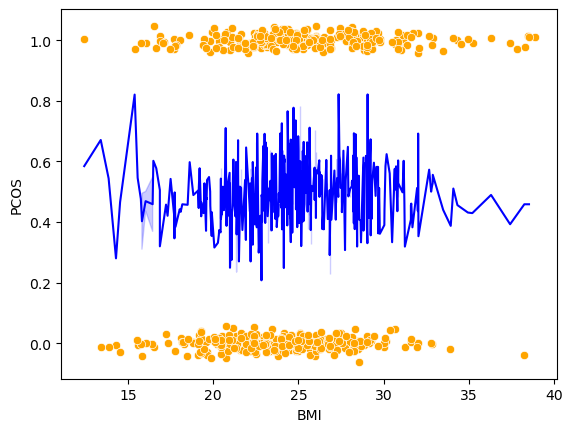

In [1891]:
#Jittering points to better see the density of points in any given region of the plot
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.BMI,0), y = jitter(data.PCOS,0), data = data, color = 'orange')
logit_model = smf.logit(formula = 'PCOS~BMI', data = data).fit()
sns.lineplot(x = 'BMI', y= logit_model.predict(train), data = data, color = 'blue') 
print(logit_model.llf) #Printing the log likelihood to compare it with the next model we build

          Predicted 0  Predicted 1
Actual 0        172.0        115.0
Actual 1        123.0        164.0

Classification accuracy = 58.5366%
False Negative = 42.8571%
False Positive = 40.0697%


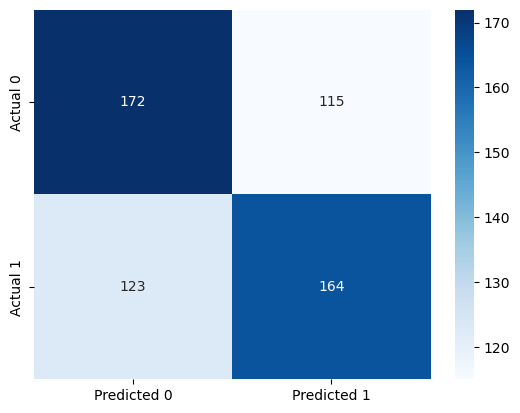

In [1892]:
confusion_matrix_test(data, data.PCOS, logit_model, cutoff = 0.5)

In [1893]:
#Binning weight
binned_BMI = pd.qcut(data['BMI'], 6, retbins=True)
data['BMI_binned'] = binned_BMI[0]

In [1894]:
#Finding percentage of people having diabetes in each Age bin
BMI_data = data.groupby('BMI_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
BMI_data

,BMI_binned,PCOS_percent,nobs
0,"(12.417, 20.957]",0.364583,96
1,"(20.957, 22.959]",0.375000,96
2,"(22.959, 24.462]",0.505263,95
3,"(24.462, 25.97]",0.531250,96
4,"(25.97, 28.453]",0.515789,95
5,"(28.453, 38.901]",0.708333,96


Text(0.5, 0, 'BMI_bin')

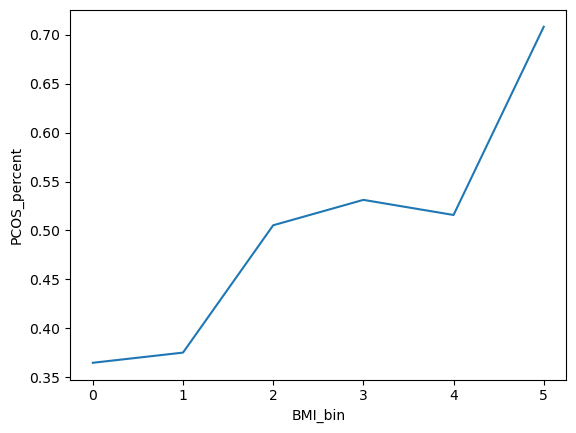

In [1895]:
sns.lineplot(x = BMI_data.index, y = BMI_data['PCOS_percent'])
plt.xlabel('BMI_bin')

In [1896]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data1):
    binned_BMI = pd.qcut(data['BMI'], 6,retbins=True)
    bins = binned_BMI[1]
    data1['BMI_binned'] = pd.cut(data1['BMI'],bins = bins)
    dum = pd.get_dummies(data1.BMI_binned,drop_first = True)
    dum.columns = ['BMI'+str(x) for x in range(1,len(bins)-1)]
    data1 = pd.concat([data1,dum], axis = 1)
    return data1

In [1897]:
#Binning age using the function var_transform()
data = var_transform(data)

Text(0.5, 0, 'BMI_bin')

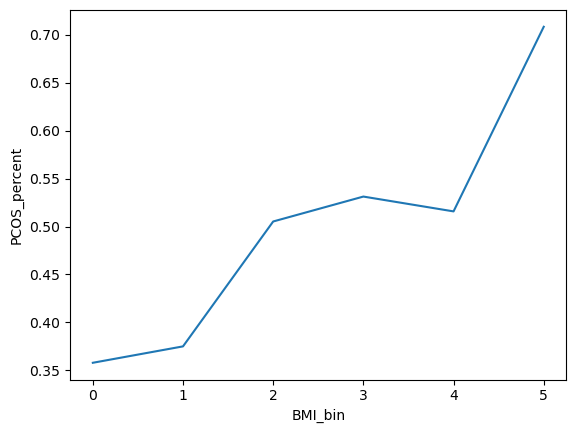

In [1898]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
BMI_data = data.groupby('BMI_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = BMI_data.index, y= BMI_data['PCOS_percent'])
plt.xlabel('BMI_bin')

Optimization terminated successfully.
         Current function value: 0.666265
         Iterations 5


<AxesSubplot:xlabel='BMI', ylabel='PCOS'>

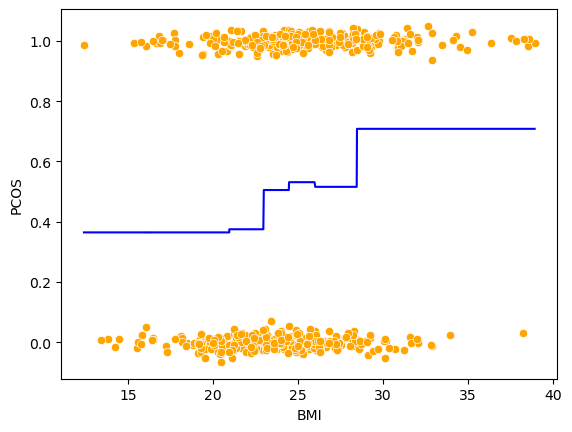

In [1899]:
#Model with binned Age
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.BMI,0), y = jitter(data.PCOS,0), data = data, color = 'orange')
logit_model = smf.logit(formula = 'PCOS~' + '+'.join(['BMI'+str(x) for x in range(1,6)]), data = data).fit()
sns.lineplot(x = 'BMI', y= logit_model.predict(data), data = data, color = 'blue') 



          Predicted 0  Predicted 1
Actual 0        121.0        166.0
Actual 1         71.0        216.0

Classification accuracy = 58.7108%
False Negative = 24.7387%
False Positive = 57.8397%


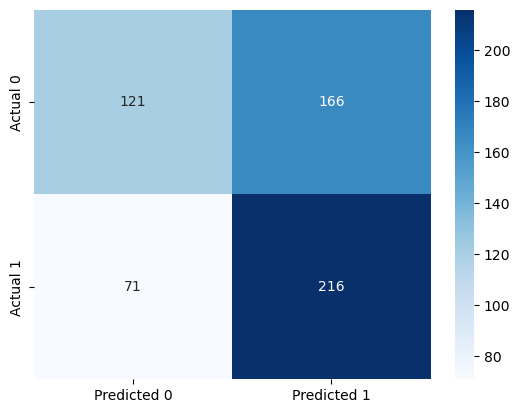

In [1900]:
confusion_matrix_test(data, data.PCOS, logit_model, cutoff = 0.5)

# Testing Interactions

#### Testing Age

In [1901]:
data["age"].describe()

count    574.000000
mean      30.682927
std        5.306700
min       20.000000
25%       27.000000
50%       30.000000
75%       34.000000
max       48.000000
Name: age, dtype: float64

In [1902]:
sub_age = data[data.age > 31]

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

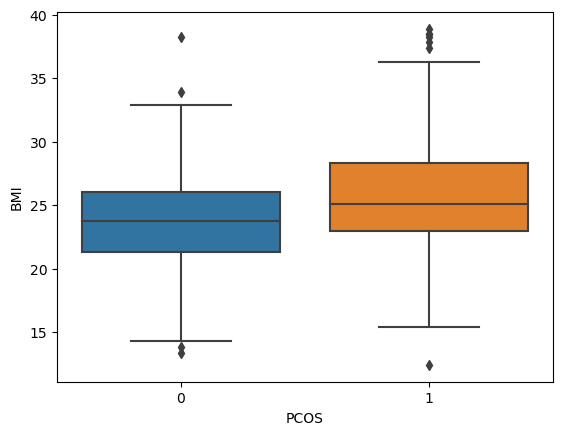

In [1903]:
sns.boxplot(x = "PCOS", y = "BMI", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

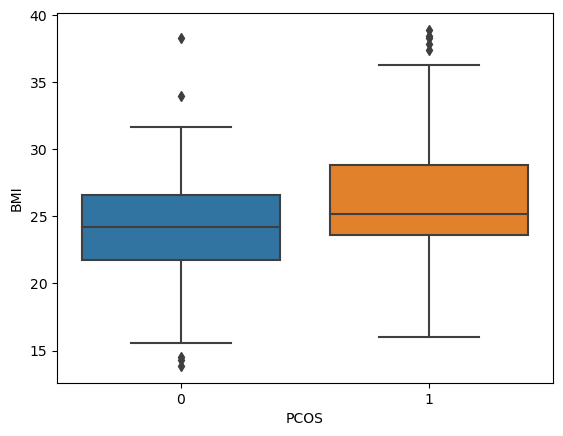

In [1904]:
sns.boxplot(x = "PCOS", y = "BMI", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='marriage_years'>

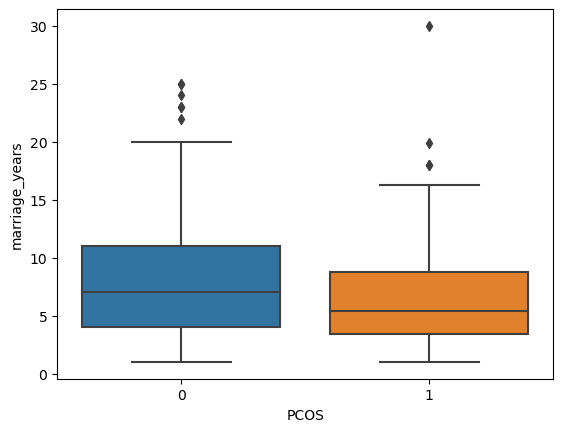

In [1905]:
sns.boxplot(x = "PCOS", y = "marriage_years", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='marriage_years'>

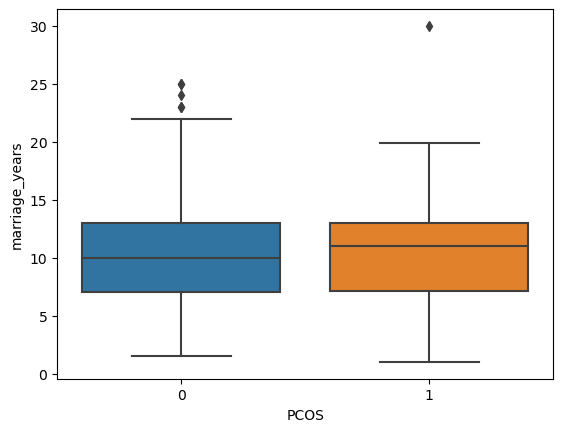

In [1906]:
sns.boxplot(x = "PCOS", y = "marriage_years", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

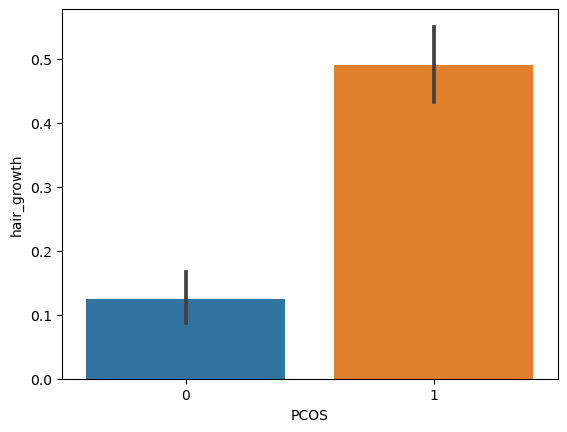

In [1907]:
sns.barplot(x = "PCOS", y = "hair_growth", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

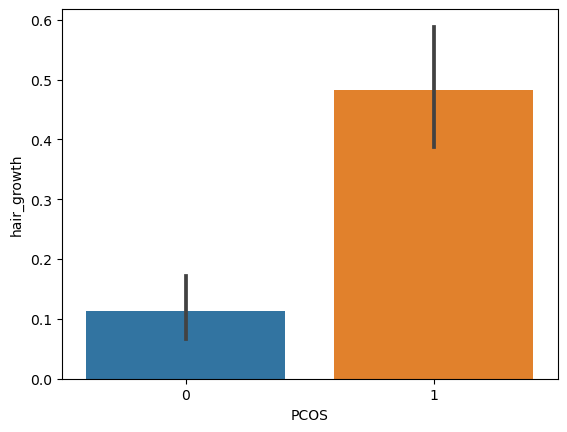

In [1908]:
sns.barplot(x = "PCOS", y = "hair_growth", data = sub_age)

Consider adding age*hair_growth

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

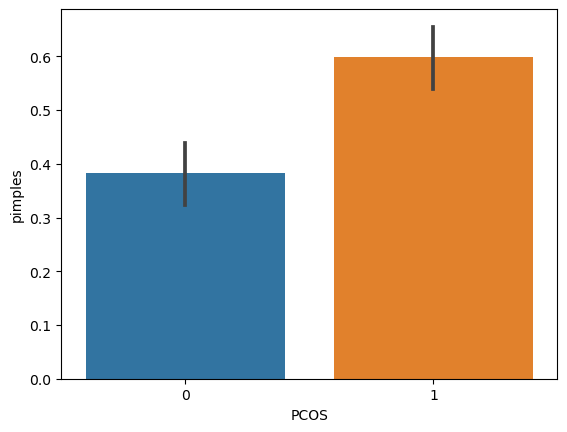

In [1909]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

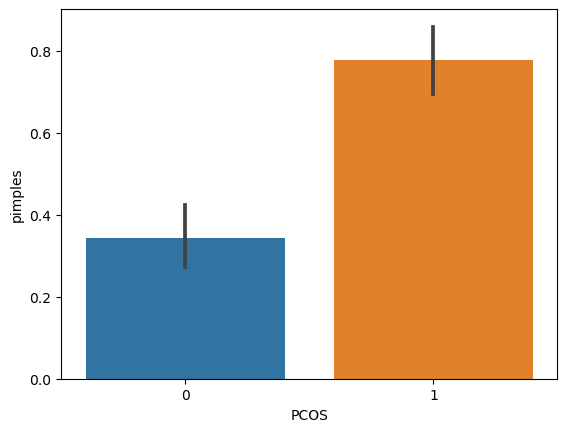

In [1910]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

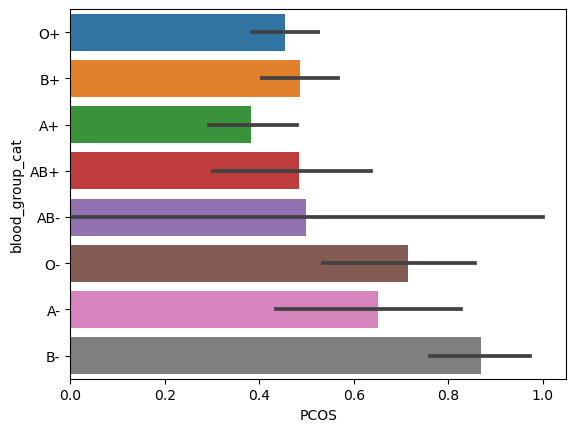

In [1911]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

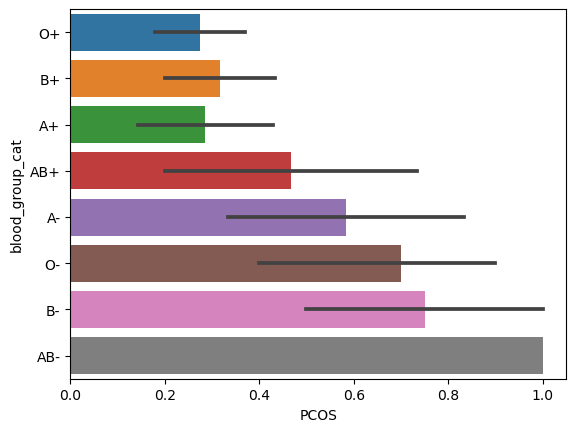

In [1912]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_age)

Consider adding blood_group_cat*age

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

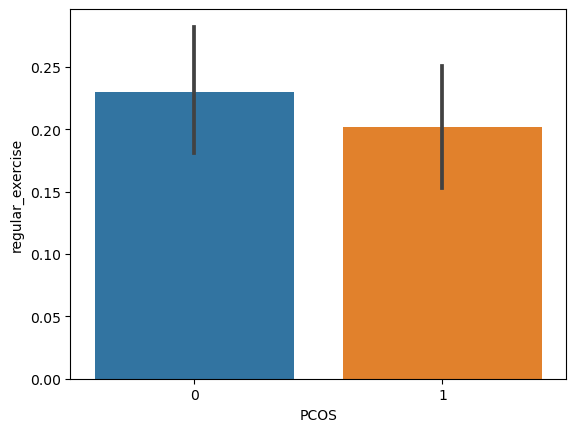

In [1913]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

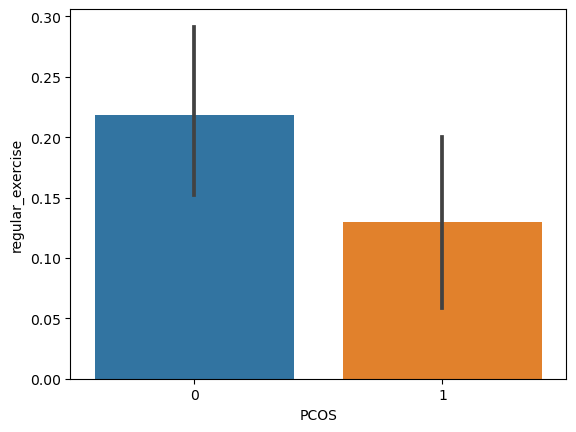

In [1914]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

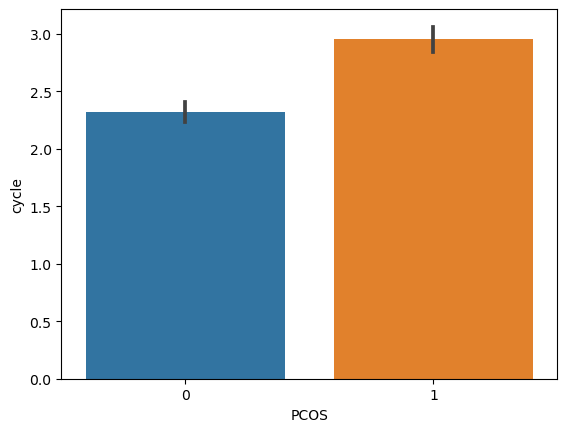

In [1915]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

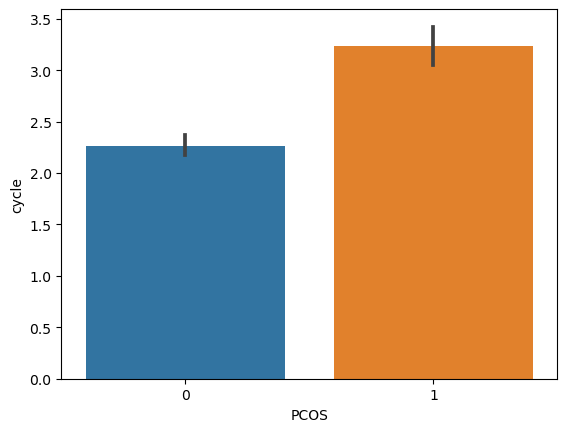

In [1916]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_age)

#### Test on BMI

In [1917]:
data["BMI"].describe()

count    574.000000
mean      24.645334
std        4.175663
min       12.417882
25%       22.140197
50%       24.462387
75%       27.171620
max       38.900714
Name: BMI, dtype: float64

In [1918]:
sub_bmi = data[data.BMI > 24]

In [1962]:
sub_bmi_neg = data[data.BMI <= 24]

<AxesSubplot:xlabel='PCOS', ylabel='age'>

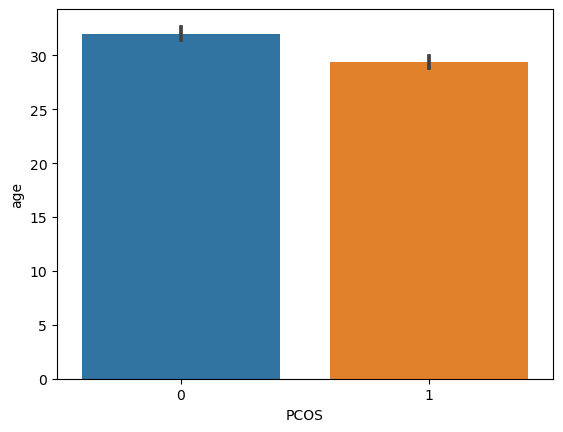

In [1960]:
sns.barplot(x = "PCOS", y = "age", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='age'>

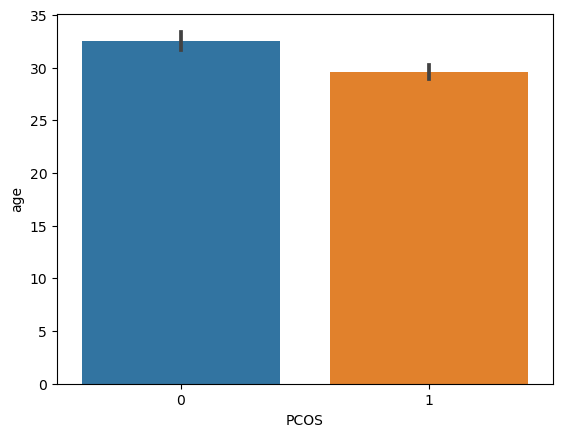

In [1961]:
sns.barplot(x = "PCOS", y = "age", data = sub_bmi)

<AxesSubplot:xlabel='PCOS', ylabel='pregnant'>

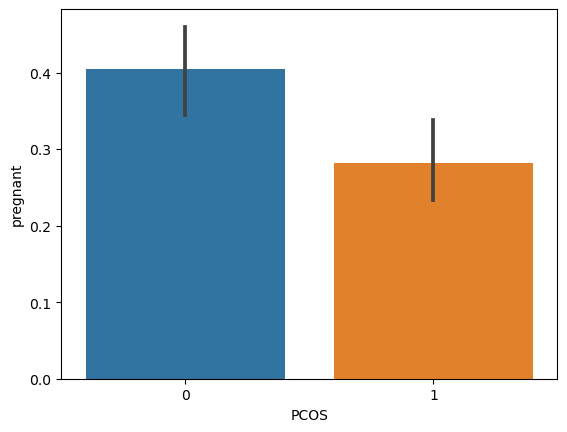

In [1919]:
sns.barplot(x = "PCOS", y = "pregnant", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pregnant'>

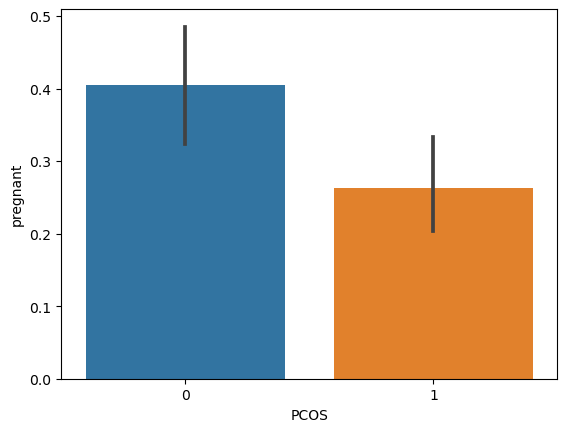

In [1920]:
sns.barplot(x = "PCOS", y = "pregnant", data = sub_bmi)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

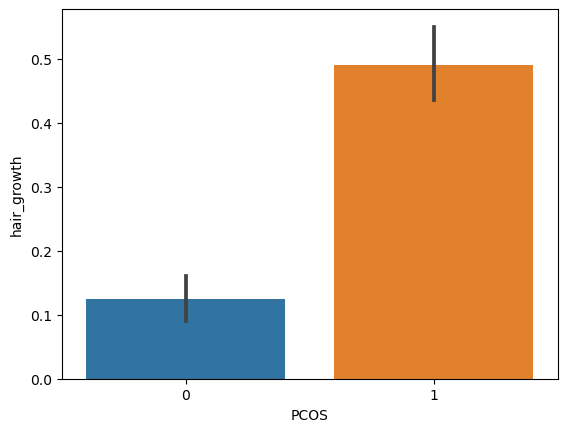

In [1921]:
sns.barplot(x = "PCOS", y = "hair_growth", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

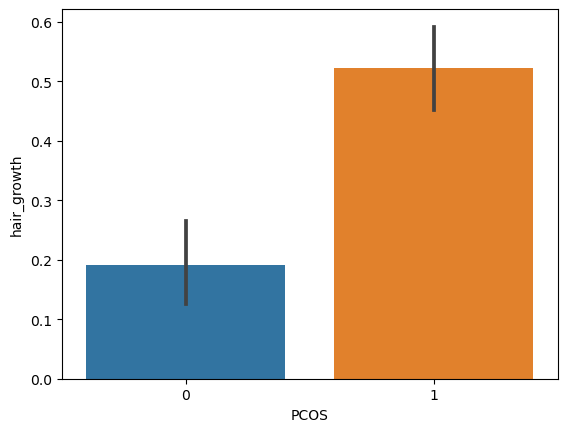

In [1922]:
sns.barplot(x = "PCOS", y = "hair_growth", data = sub_bmi)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

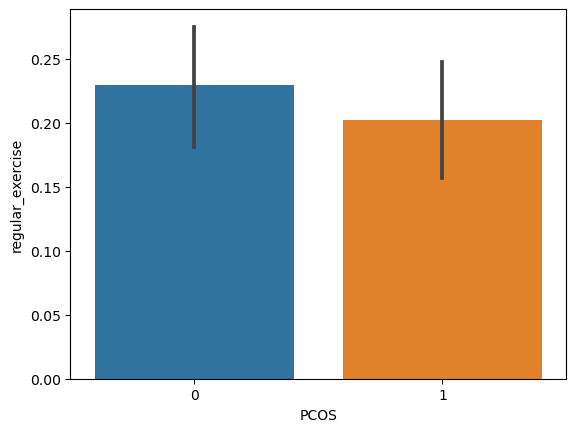

In [1983]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

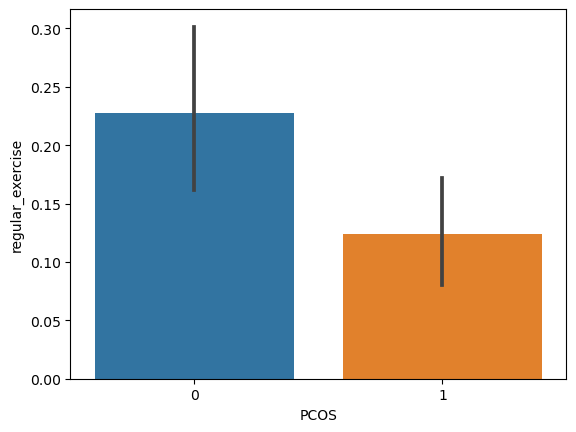

In [1984]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = sub_bmi)

Consider adding BMI*regular_exercise

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

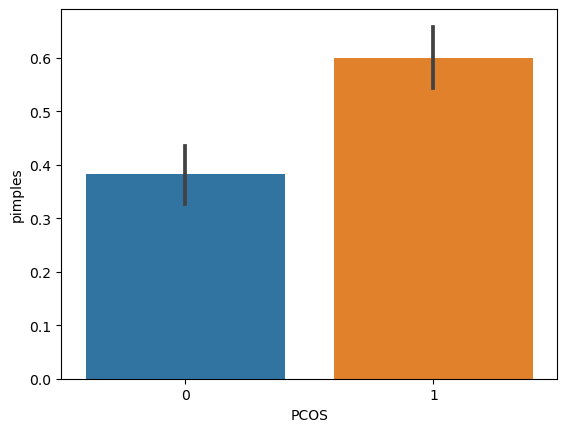

In [1925]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

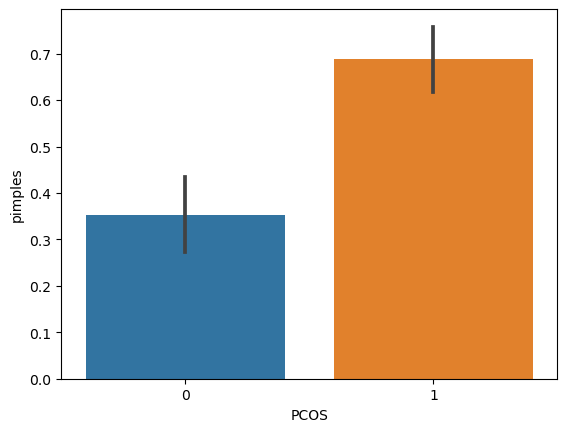

In [1926]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_bmi)

Consider adding BMI*pimples

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

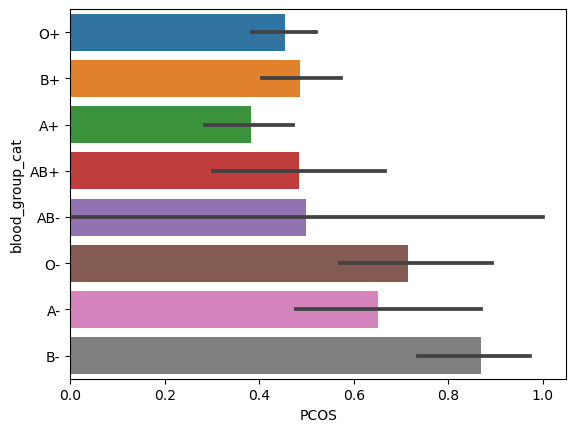

In [1927]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

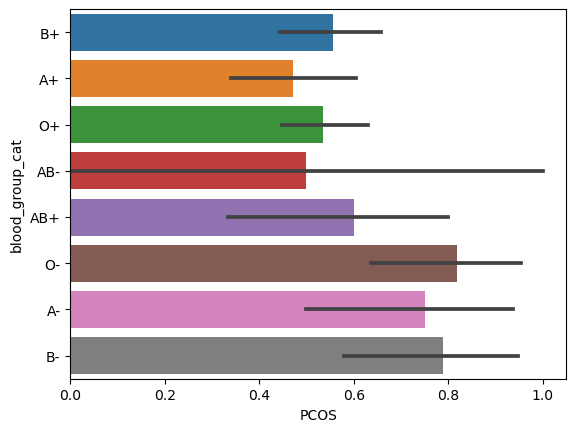

In [1928]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_bmi)

Consider adding blood_group_cat*BMI

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

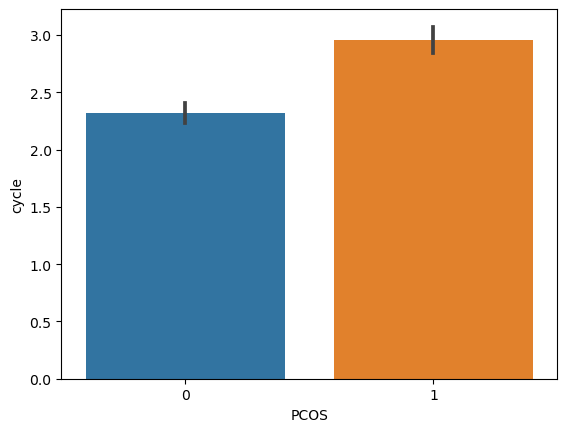

In [1929]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

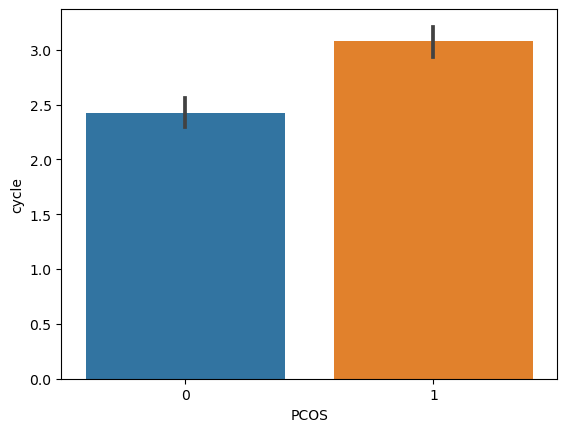

In [1930]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_bmi)

#### Testing hw_ratio

In [1931]:
data["hw_ratio"].describe()

count    574.000000
mean       1.126008
std        0.058091
min        1.021277
25%        1.082736
50%        1.117647
75%        1.166667
max        1.323529
Name: hw_ratio, dtype: float64

In [1932]:
sub_hw = data[data.hw_ratio > 1.124]

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

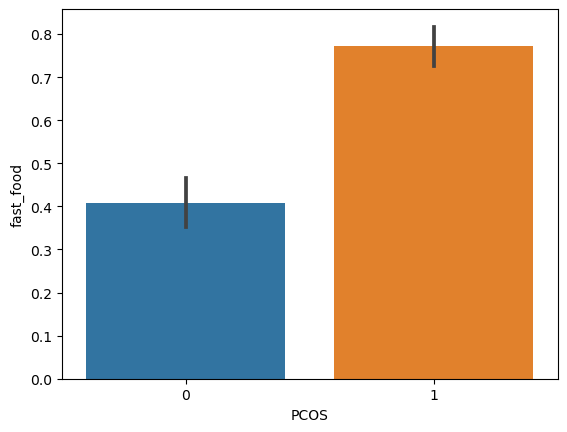

In [1933]:
sns.barplot(x = "PCOS", y = "fast_food", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

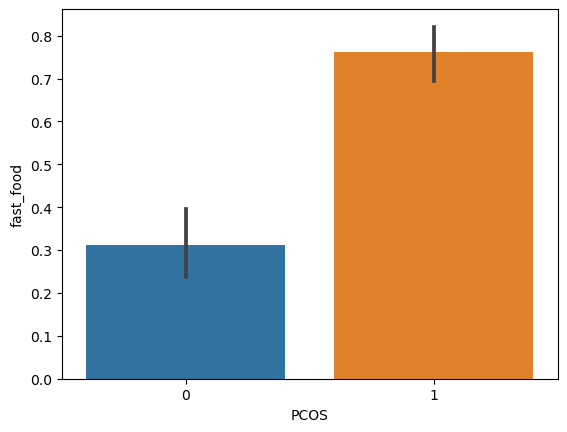

In [1934]:
sns.barplot(x = "PCOS", y = "fast_food", data = sub_hw)

Consider adding hw_ratio*fast_food

#### Testing regular exercise

In [1935]:
data["regular_exercise"].describe()

count    574.000000
mean       0.216028
std        0.411892
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: regular_exercise, dtype: float64

In [1936]:
sub_reg = data[data.regular_exercise > 0.225862]

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

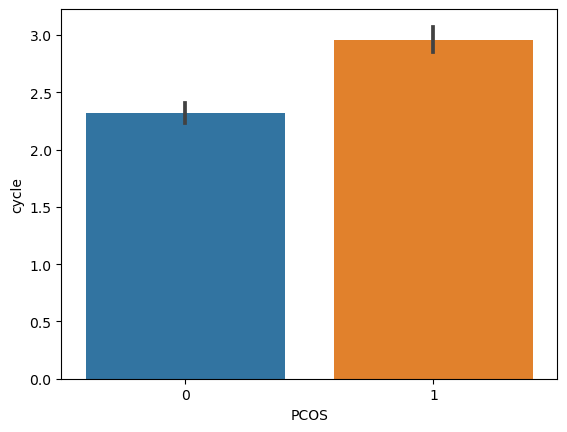

In [1937]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

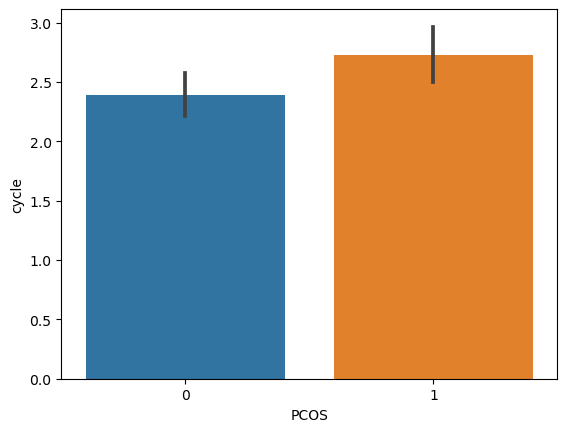

In [1938]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_reg)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

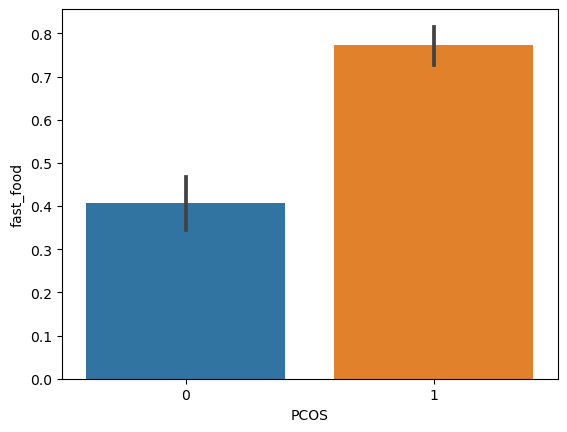

In [1939]:
sns.barplot(x = "PCOS", y = "fast_food", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

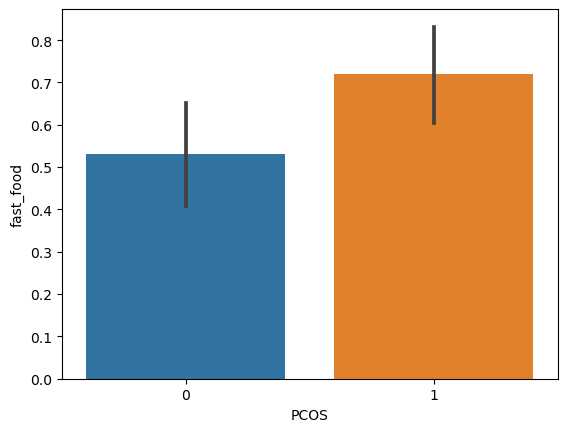

In [1940]:
sns.barplot(x = "PCOS", y = "fast_food", data = sub_reg)

Consider adding fast_food*regular_exercise

#### Testing pregnant

In [1941]:
data["pregnant"].describe()

count    574.000000
mean       0.343206
std        0.475194
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: pregnant, dtype: float64

In [1942]:
sub_preg = data[data.pregnant > 0.327]

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

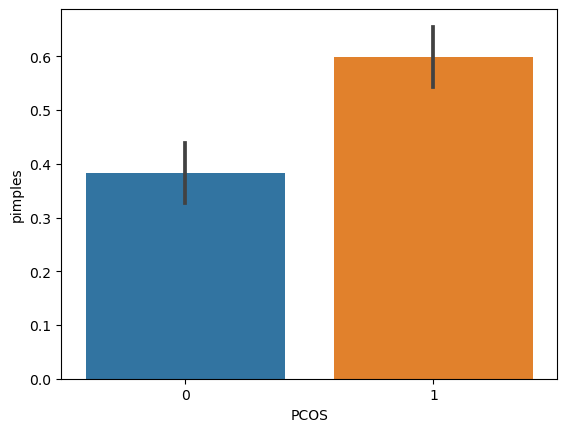

In [1943]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

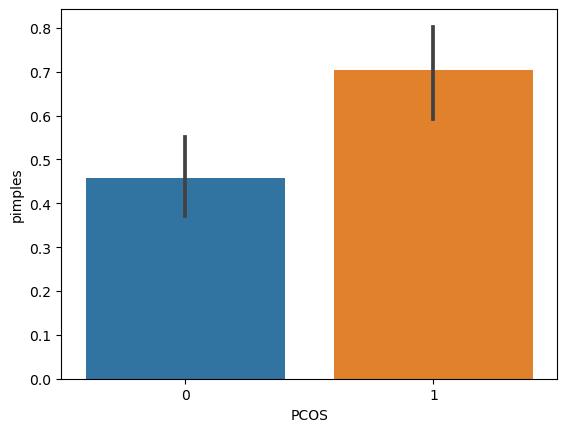

In [1944]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_preg)

Consider adding pimples*pregnant

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

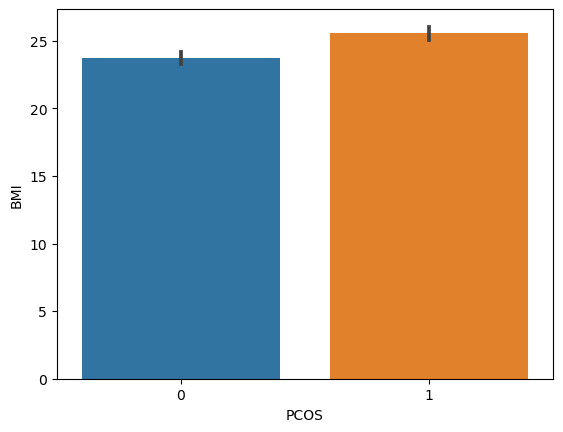

In [1945]:
sns.barplot(x = "PCOS", y = "BMI", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

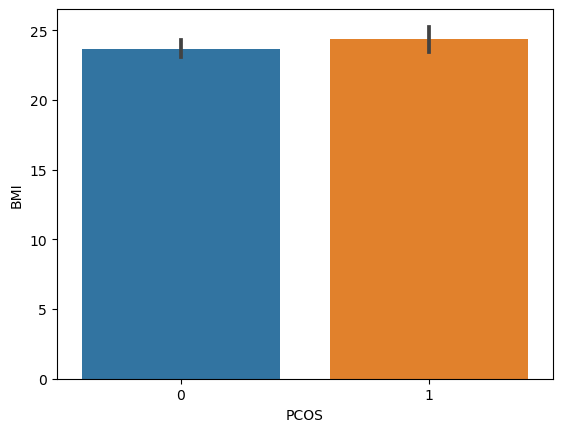

In [1946]:
sns.barplot(x = "PCOS", y = "BMI", data = sub_preg)

#### Testing pulse_rate 

In [1947]:
data["pulse_rate"].describe()

count    574.000000
mean      73.153310
std        4.258347
min       13.000000
25%       72.000000
50%       72.000000
75%       74.000000
max       82.000000
Name: pulse_rate, dtype: float64

In [1948]:
sub_pulse = data[data.pulse_rate > 73]

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

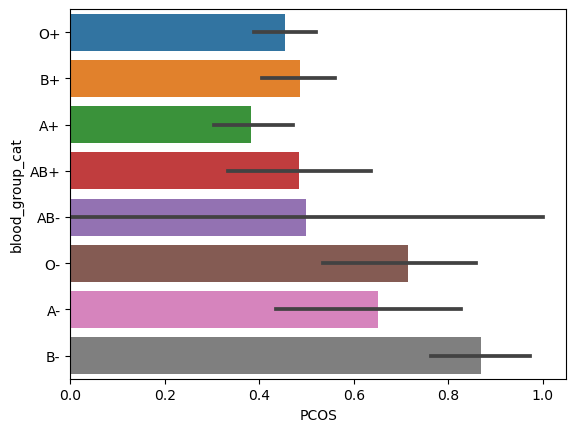

In [1949]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

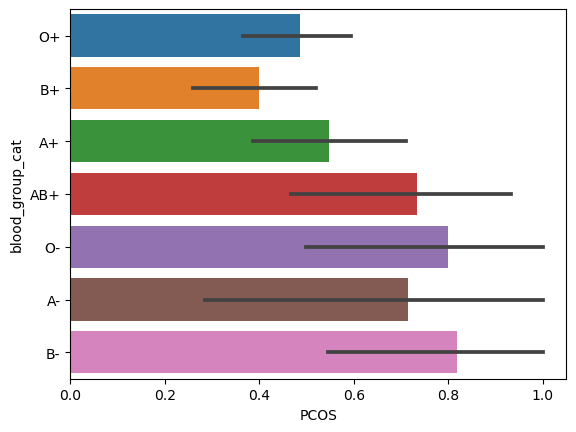

In [1950]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_pulse)

Consider adding pulse_rate*blood_group_cat

# VIF

In [1986]:
data.columns

Index(['PCOS', 'age', 'weight', 'height', 'BMI', 'pulse_rate', 'RR',
       'marriage_years', 'fast_food', 'pregnant', 'number_abortions',
       'hw_ratio', 'regular_exercise', 'cycle', 'hair_growth', 'pimples',
       'Blood Group', 'skin_dark', 'blood_group_cat', 'age_binned',
       'BMI_binned', 'BMI1', 'BMI2', 'BMI3', 'BMI4', 'BMI5'],
      dtype='object')

In [1998]:
X = data[['age','BMI','pulse_rate','marriage_years', "fast_food", "pregnant", "number_abortions", "hw_ratio", "regular_exercise", "cycle", "hair_growth", "pimples", "skin_dark", 'Blood Group']]
X.columns[1:]

Index(['BMI', 'pulse_rate', 'marriage_years', 'fast_food', 'pregnant',
       'number_abortions', 'hw_ratio', 'regular_exercise', 'cycle',
       'hair_growth', 'pimples', 'skin_dark', 'Blood Group'],
      dtype='object')

In [1999]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)


             feature         VIF
0              const  807.112218
1                age    1.854961
2                BMI    1.177890
3         pulse_rate    1.040935
4     marriage_years    1.875929
5          fast_food    1.280096
6           pregnant    1.056657
7   number_abortions    1.144124
8           hw_ratio    1.058045
9   regular_exercise    1.048046
10             cycle    1.194332
11       hair_growth    1.272133
12           pimples    1.123131
13         skin_dark    1.234697
14       Blood Group    1.060373


Since the VIF for constant is very large. All predictor VIFs are very closer to 1, indicating they do not have issues with collinearity. 

# Logistic Regression

In [1951]:
data.columns

Index(['PCOS', 'age', 'weight', 'height', 'BMI', 'pulse_rate', 'RR',
       'marriage_years', 'fast_food', 'pregnant', 'number_abortions',
       'hw_ratio', 'regular_exercise', 'cycle', 'hair_growth', 'pimples',
       'Blood Group', 'skin_dark', 'blood_group_cat', 'age_binned',
       'BMI_binned', 'BMI1', 'BMI2', 'BMI3', 'BMI4', 'BMI5'],
      dtype='object')

In [1980]:
model1 = smf.logit("PCOS ~ pregnant*pimples + pregnant + skin_dark +skin_dark*fast_food + pregnant*weight + blood_group_cat*pulse_rate + age + cycle + marriage_years + fast_food + pimples + hair_growth + number_abortions + regular_exercise*fast_food + regular_exercise*cycle + hw_ratio*fast_food + hw_ratio*pimples + BMI*pimples + BMI*regular_exercise + blood_group_cat*age + " + '+'.join(['BMI'+str(x) for x in range(1,6)]), data = data).fit()
model1.summary()


         Current function value: 0.358955
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  574
Model:                          Logit   Df Residuals:                      525
Method:                           MLE   Df Model:                           48
Date:                Mon, 27 Feb 2023   Pseudo R-squ.:                  0.4821
Time:                        18:47:26   Log-Likelihood:                -206.04
converged:                      False   LL-Null:                       -397.87
Covariance Type:            nonrobust   LLR p-value:                 6.926e-54
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.3312      9.346     -0.142      0.887     -19.650      16.987
blood_group_cat[T.A-]                58.5964     18.980      3.087      0.002      21.397      95.796
blood_group_cat[T.AB+]              -18.5664     18.559     -1.000      0.317     -54.941      17.809
blood_group_cat[T.AB-]               -0.0685        nan        nan        nan         nan         nan
blood_group_cat[T.B+]                22.9128     11.173      2.051      0.040       1.014      44.812
blood_group_cat[T.B-]                25.0435     26.637      0.940      0.347     -27.163      77.251
blood_group_cat[T.O+]                13.9536      9.133      1.528      0.127      -3.948      31.855
blood_group_cat[T.O-]               -39.2629     23.460     -1.674      0.094     -85.243       6.718
pregnant                              0.5590      1.756      0.318      0.750      -2.883       4.001
pimples                             -18.0740      6.181     -2.924      0.003     -30.189      -5.959
pregnant:pimples                      0.5079      0.577      0.881      0.378      -0.622       1.638
skin_dark                             2.1914      0.561      3.907      0.000       1.092       3.291
fast_food                           -13.8817      5.728     -2.423      0.015     -25.109      -2.655
skin_dark:fast_food                  -0.2630      0.652     -0.403      0.687      -1.541       1.015
weight                                0.0371      0.032      1.165      0.244      -0.025       0.099
pregnant:weight                      -0.0267      0.029     -0.919      0.358      -0.084       0.030
pulse_rate                            0.1661      0.112      1.486      0.137      -0.053       0.385
blood_group_cat[T.A-]:pulse_rate     -0.7236      0.256     -2.823      0.005      -1.226      -0.221
blood_group_cat[T.AB+]:pulse_rate     0.2172      0.241      0.900      0.368      -0.256       0.690
blood_group_cat[T.AB-]:pulse_rate    -2.3186        nan        nan        nan         nan         nan
blood_group_cat[T.B+]:pulse_rate     -0.2787      0.151     -1.847      0.065      -0.574       0.017
blood_group_cat[T.B-]:pulse_rate     -0.3158      0.382     -0.827      0.408      -1.064       0.432
blood_group_cat[T.O+]:pulse_rate     -0.1495      0.121     -1.237      0.216      -0.386       0.087
blood_group_cat[T.O-]:pulse_rate      0.5078      0.334      1.519      0.129      -0.147       1.163
age                                  -0.0444      0.085     -0.520      0.603      -0.212       0.123
blood_group_cat[T.A-]:age            -0.1454      0.176     -0.825      0.409      -0.491       0.200
blood_group_cat[T.AB+]:age            0.0761      0.146      0.522      0.602      -0.210       0.362
blood_group_cat[T.AB-]:age            5.6531        nan        nan        nan         nan         nan
blood_group_cat[T.B+]:age            -0.0556      0.095     -0.586      0.558  

          Predicted 0  Predicted 1
Actual 0        244.0         43.0
Actual 1         46.0        241.0

Classification accuracy = 84.4948%
False Negative = 16.0279%
False Positive = 14.9826%


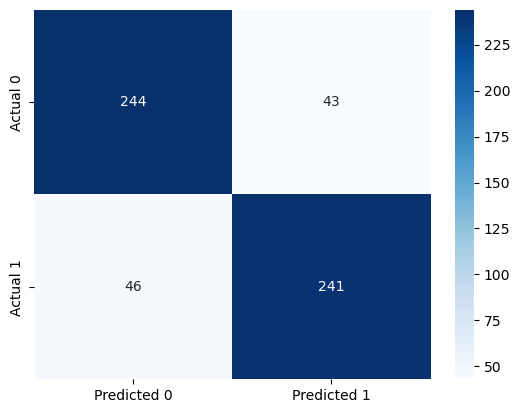

In [1981]:
confusion_matrix_test(data, data.PCOS, model1, cutoff = 0.5)

          Predicted 0  Predicted 1
Actual 0        216.0         71.0
Actual 1         26.0        261.0

Classification accuracy = 83.1010%
False Negative = 9.0592%
False Positive = 24.7387%


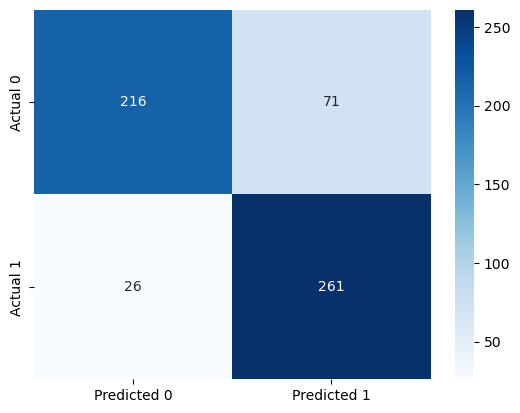

In [1982]:
confusion_matrix_test(data, data.PCOS, model1, cutoff = 0.33)